In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_files = ["data/"+f for f in os.listdir("data/") if f.endswith('.csv')]

In [3]:
csv_files

["data/2017-01-21 Women's March.csv",
 "data/2018-01-Women's March.csv",
 'data/2017-08.csv',
 'data/2017-09.csv',
 'data/2017-02.csv',
 'data/2017-03.csv',
 'data/2017-07.csv',
 'data/2017-06.csv',
 'data/2017-12.csv',
 'data/2017-04.csv',
 'data/2017-10.csv',
 'data/2017-11.csv',
 'data/2017-05.csv',
 'data/2018-01-Other.csv']

In [4]:
def mentions_trump(claim):
    if 'Ivanka' in claim:
        return False
    if 'Trump' in claim or 'impeach' in claim.lower():
        return True
    else:
        return False

def mentions_race(claim):
    return any(word in claim.lower() for word in ['racial', 'racism', 'racist', 'race relations',
                                                  'anti-semi', 'black lives matter', 'white supre',
                                                  'nazi', 'white nationalist', 'white lives'])

def blm(actor):
    try:
        return "black lives matter" in actor.lower()
    except AttributeError:
        return False

def immigration(claim):
    return any(w in claim.split() for w in ('ICE', 'DACA')) or any(x in claim.lower() for x in ('dreamers',
                                                                                     'deportation', 'border wall',
                                                                                    'dream act', 'immigra',
                                                                                    'sanctuary', 'travel ban',
                                                                                    'muslim ban'))

def sexual_assault(claim):
    if "rape" in claim.split():
        return True
    else:
        return any(word in claim.lower() for word in ['domestic violence', 'sexual', 'metoo',
                                                      #'roy moore',
                                                     'take back the night'])


In [5]:
def process_file(file):

    raw_df = pd.read_csv(file)
    
    # Get year and month from filename
    raw_df['Year'] = file[5:9]
    raw_df['Month'] = file[10:12]
    
    # Convert 'EstimateHigh' if it's not coded as numeric
    if raw_df['EstimateHigh'].dtype=='O':
        raw_df['EstimateHigh'] = pd.to_numeric(raw_df['EstimateHigh'], errors='coerce')
    
    # Make avg estimate out of estimatelow and estimatehigh
    raw_df['Avg_Estimate'] = (raw_df['EstimateLow'] + raw_df['EstimateHigh']) / 2

    # Replace with avg where BestGuess is None
    raw_df['BestGuess'] = raw_df['BestGuess'].where(raw_df['BestGuess']==None,raw_df['Avg_Estimate'])
    
    # Find the column "Pro/Anti" and rename it to "ProAnti"
    p_a = next(x for x in raw_df.columns.values if x.startswith('Pro'))
    raw_df.rename(columns={p_a: 'ProAnti'}, inplace=True)
    
    if 'CityTown' in raw_df.columns.values:
        raw_df.rename(columns={'CityTown': 'City/Town'}, inplace=True)
        
    if 'protest' in raw_df.columns.values:
        raw_df.rename(columns={'protest': 'EventType'}, inplace=True)
    
    # Select columns of interest
    raw_df = raw_df[['City/Town', 'StateTerritory', 'Year', 'Month', 'Date', 'BestGuess', 'Actor',
                     'Claim', 'ProAnti', 'EventType']]
    
    # Drop all rows where BestGuess or Claim or StateTerritory is NaN
    raw_df = raw_df.dropna(subset=['BestGuess', 'Claim', 'StateTerritory', 'Date'])
    
    raw_df['Trump'] = raw_df['Claim'].apply(lambda x: mentions_trump(x))
    raw_df['Race'] = raw_df['Claim'].apply(lambda x: mentions_race(x)) | raw_df['Actor'].apply(lambda x: blm(x))
    raw_df['Immigration'] = raw_df['Claim'].apply(lambda x: immigration(x))
    raw_df['MeToo'] = raw_df['Claim'].apply(lambda x: sexual_assault(x))
    
    return raw_df

In [6]:
# Ignore Women's March files for now
raw_dfs = [process_file(f) for f in csv_files[2:]]

In [7]:
full_df = pd.concat(raw_dfs, ignore_index=True)

In [8]:
full_df.shape

(5969, 14)

In [9]:
full_df.columns.values

array(['City/Town', 'StateTerritory', 'Year', 'Month', 'Date', 'BestGuess',
       'Actor', 'Claim', 'ProAnti', 'EventType', 'Trump', 'Race',
       'Immigration', 'MeToo'], dtype=object)

In [10]:
full_df['DateTime'] = pd.to_datetime(full_df['Date'], format='%Y-%m-%d', errors='coerce')

In [11]:
# Deal with weird dates

def change_datetime(row):
    
    # Check if DateTime year/month confirms with year, month that we got from .csv filename:
    if float(row['Year'])==float(row['DateTime'].year) and float(row['Month'])==float(row['DateTime'].month):
        return row['DateTime']
    
    # If no match, piece together new date string based on filename and last 2 digits of 'Date' column
    # Return as datetime object
    else:
        date_str = '-'.join([str(row['Year']), str(row['Month']), row['Date'][-2:]])
        return pd.to_datetime(date_str, format='%Y-%m-%d')

# Replace datetime column
full_df['DateTime'] = full_df.apply(lambda x: change_datetime(x),axis=1)

In [45]:
# full_df['MonthYear'] = full_df['Year'] + '-' + full_df['Month']

# Calculate number of days since the first date in the df
full_df['Day'] = (full_df['DateTime'] - np.min(full_df['DateTime'])).dt.days

In [46]:
full_df

,City/Town,StateTerritory,Year,Month,Date,BestGuess,Actor,Claim,ProAnti,EventType,Trump,Race,Immigration,MeToo,DateTime,MonthYear,Day
0,Austin,TX,2017,08,2017-08-01,250.0,general protestors,Protesting legislature's proposed agenda,0,protest,False,False,False,False,2017-08-01,2017-08,181
1,Austin,TX,2017,08,2017-08-01,225.0,Texas Impacts,Oppose Texas's anti-transgender bathroom bill,1,rally,False,False,False,False,2017-08-01,2017-08,181
2,Austin,TX,2017,08,2017-08-01,320.0,First Baptist Church of Austin; Friends Church...,Oppose Texas's anti-transgender bathroom bill,1,rally,False,False,False,False,2017-08-01,2017-08,181
3,Cold Spring,NY,2017,08,2017-08-01,5.0,Cold Spring Brewing workers,Protesting working conditions,0,protest; walk-out,False,False,False,False,2017-08-01,2017-08,181
4,Fort Worth,TX,2017,08,2017-08-01,400.0,United Fort Worth,Protesting TX's anti-sanctuary city bill,1,protest,False,False,True,False,2017-08-01,2017-08,181
5,Fort Worth,TX,2017,08,2017-08-01,2.0,general protestors,Counter-protest; supporting TX's anti-sanctuar...,2,protest,False,False,True,False,2017-08-01,2017-08,181
6,Hendersonville,NC,2017,08,2017-08-01,80.0,Progressive Organized Women of Hendersonville,Campaign rally for Democratic candidate Philli...,1,rally,False,False,False,False,2017-08-01,2017-08,181
7,Marquette,MI,2017,08,2017-08-01,200.0,Michigan Nurses Association,Protesting policy of understaffing hospital wo...,0,protest,False,False,False,False,2017-08-01,2017-08,181
8,New York,NY,2017,08,2017-08-01,24.0,Black Alliance for Just Immigration,Night Out for Safety and Liberation,0,rally,False,False,False,False,2017-08-01,2017-08,181
9,Philadelphia,PA,2017,08,2017-08-01,50.0,Heeding Cheyney's call,Rally to save Cheyney University,0,rally,False,False,False,False,2017-08-01,2017-08,181


In [54]:
np.max(full_df['Day'])

364

In [49]:
# number of people at Trump rallies by Month
trump_mcount = full_df[['MonthYear', 'BestGuess']][full_df['Trump']].groupby('MonthYear').sum()
trump_mcount

,BestGuess
MonthYear,
2017-02,42697.5
2017-03,25317.5
2017-04,72754.0
2017-05,20726.5
2017-06,22506.0
2017-07,20121.5
2017-08,14305.5
2017-09,26241.0
2017-10,5086.0


In [50]:
# Number of rallies by month
by_month = full_df.groupby('MonthYear').sum()
by_month

,BestGuess,Trump,Race,Immigration,MeToo,Day
MonthYear,,,,,,
2017-02,302855.0,88.0,14.0,234.0,0.0,8159
2017-03,83487.0,116.0,16.0,53.0,3.0,21079
2017-04,909573.5,106.0,15.0,22.0,8.0,50278
2017-05,114548.0,43.0,17.0,61.0,3.0,33568
2017-06,1063860.5,154.0,10.0,26.0,1.0,69738
2017-07,96990.5,85.0,18.0,26.0,2.0,79707
2017-08,190201.5,39.0,173.0,42.0,3.0,112939
2017-09,84992.0,132.0,30.0,147.0,1.0,85550
2017-10,64223.0,30.0,53.0,28.0,9.0,91884


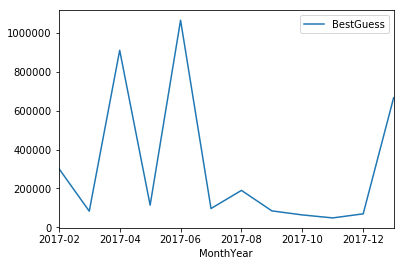

In [51]:
by_month[['BestGuess']].plot()
plt.show()
plt.close()

In [52]:
just_immigration = full_df[full_df['Immigration']][['Actor', 'Claim', 'ProAnti', 'BestGuess',
                                                   'DateTime', 'Day', 'City/Town', 'StateTerritory']]
just_immigration.shape

(778, 8)

In [55]:
np.max(just_immigration['BestGuess'])

48500.0

In [56]:
np.min(just_immigration['BestGuess'])

2.0

In [26]:
# just_trump = full_df[full_df['Trump']][['Claim', 'ProAnti', 'BestGuess']]
# just_trump.shape

# just_metoo = full_df[full_df['MeToo']][['Actor', 'Claim', 'ProAnti', 'BestGuess',
#                                         'DateTime', 'City/Town', 'StateTerritory']]
# just_metoo.shape

(979, 3)

In [53]:
# Write out just immigration

just_immigration.to_csv('immigration.csv', index=False)

In [10]:
# Write out

out_df = full_df.copy()

# Write issue columns as int (0 or 1)
for bool_col in ('Trump', 'Race', 'Immigration'):
    out_df[bool_col] = out_df[bool_col].astype(int)

out_df.to_csv('full.csv')

In [ ]:
# encoding in CSV is weird -- fix!!!

In [107]:
# Write out by month

by_month.to_csv('by_month.csv')